In [1]:
import numpy as np
import pandas as pd
import os
from re import search
import shutil
import natsort
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
DIR =r"images"

In [6]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


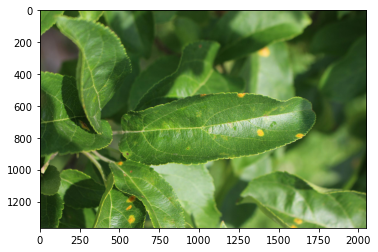

In [8]:
img1 = Image.open("images/OriginalDataset/Test_0.jpg")
plt.imshow(img1)
plt.show()

## Preparing Training data

In [9]:
class_names = train.loc[:,"healthy":].columns ##Getting names of the different classes
print(class_names)

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [33]:
count = 0
train['label'] = 0
for i in class_names:
    train['label'] = train['label'] + train[i]*count
    count = count+1

In [11]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [12]:
DIR = r"images\OriginalDataset"

In [13]:
def get_label_img(img):
    if(search("Train",img)):
        img = img.split('.')[0]
        label = train.loc[train['image_id']==img]['label']
        return label

In [14]:
def create_train_data():
    images = natsort.natsorted(os.listdir(DIR))
    for img in tqdm(images):
        label = get_label_img(img)
        path = os.path.join(DIR,img)
        
        if(search("Train",img)):
            if(img.split("_")[1].split(".")[0]) and label.item()==0:
                shutil.copy(path,r'C:\Users\mayes\Projects\apple-folier-disease\images\train\healthy')
            elif(img.split("_")[1].split(".")[0]) and label.item()==1:
                shutil.copy(path,r'C:\Users\mayes\Projects\apple-folier-disease\images\train\multiple_disease')
            elif(img.split("_")[1].split(".")[0]) and label.item()==2:
                shutil.copy(path,r'C:\Users\mayes\Projects\apple-folier-disease\images\train\rust')
            elif(img.split("_")[1].split(".")[0]) and label.item()==3:
                shutil.copy(path,r'C:\Users\mayes\Projects\apple-folier-disease\images\train\scab')
        elif search("Test",img):
            shutil.copy(path,r'C:\Users\mayes\Projects\apple-folier-disease\images\test')

In [15]:
train_dir = create_train_data() ##This is already done if you download the images folder from this repository.

100%|██████████| 3642/3642 [01:56<00:00, 31.38it/s]


In [ ]:
DIR

## Data Preprocessing

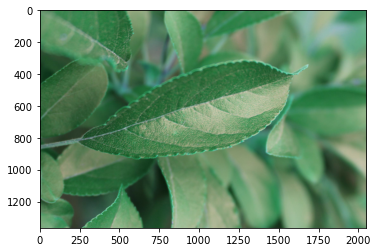

In [16]:
Train_DIR = r"images\train"
categories = ['healthy','multiple_diseases','rust','scab']

for j in categories:
    path = os.path.join(Train_DIR,j)
    for img in os.listdir(path):
        old_image = cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
        plt.imshow(old_image)
        plt.show()
        break
    break

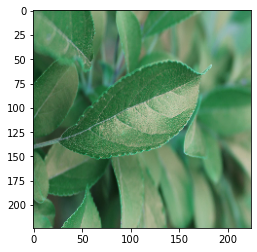

In [17]:
IMG_SIZE = 224
new_image = cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_image)
plt.show()

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,MaxPooling2D


In [19]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [20]:
datagen = ImageDataGenerator(rescale = 1./255, ##Normalization
                            shear_range = 0.2, ##
                            horizontal_flip=True, ##Another image generated using one horizontal flip for better training
                            vertical_flip=True, ##Another image generated using one vertical flip for better training
                            validation_split = 0.2)

train_datagen = datagen.flow_from_directory(r"images\train",
                                           target_size = (IMG_SIZE,IMG_SIZE),
                                           batch_size = 16,
                                           class_mode = 'categorical',
                                           subset = 'training')
val_datagen = datagen.flow_from_directory(r"images\train",
                                           target_size = (IMG_SIZE,IMG_SIZE),
                                           batch_size = 16,
                                           class_mode = 'categorical',
                                           subset = 'validation')

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


In [21]:
model=Sequential()

model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(4,activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [22]:
checkpoint=ModelCheckpoint(r"apple-folier-disease\models\apple2.h5",
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]

In [23]:
model_history=model.fit_generator(train_datagen,validation_data=val_datagen,
                                 epochs=30,
                                 steps_per_epoch=train_datagen.samples//16,
                                 validation_steps=val_datagen.samples//16,
                                 callbacks=callbacks)

C:\Users\mayes\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
91/91 [==============================] - 95s 1s/step - loss: 1.2841 - accuracy: 0.3234 - val_loss: 1.2645 - val_accuracy: 0.3523

Epoch 00001: val_loss improved from inf to 1.26448, saving model to C:\Users\mayes\Projects\apple-folier-disease\models\apple2.h5
Epoch 2/30
91/91 [==============================] - 86s 949ms/step - loss: 1.2724 - accuracy: 0.3293 - val_loss: 1.2367 - val_accuracy: 0.3494

Epoch 00002: val_loss improved from 1.26448 to 1.23667, saving model to C:\Users\mayes\Projects\apple-folier-disease\models\apple2.h5
Epoch 3/30
91/91 [==============================] - 86s 944ms/step - loss: 1.2547 - accuracy: 0.3541 - val_loss: 1.2236 - val_accuracy: 0.4062

Epoch 00003: val_loss improved from 1.23667 to 1.22361, saving model to C:\Users\mayes\Projects\apple-folier-disease\models\apple2.h5
Epoch 4/30
91/91 [==============================] - 82s 896ms/step - loss: 1.1771 - accuracy: 0.4367 - val_loss: 1.0069 - val_accuracy: 0.5455

Epoch 00004: val_loss improve

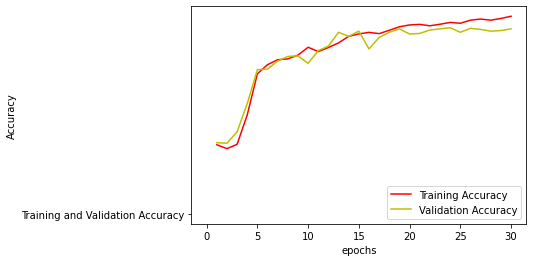

In [24]:
train_acc=model_history.history['accuracy']
valid_acc = model_history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs,train_acc,'r',label="Training Accuracy")
plt.plot(epochs,valid_acc,'y',label ="Validation Accuracy")

plt.plot("Training and Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

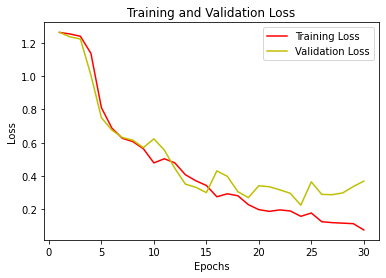

In [25]:
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(1,31)
plt.plot(epochs,loss_train,'r',label='Training Loss')
plt.plot(epochs,loss_val,'y',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

2


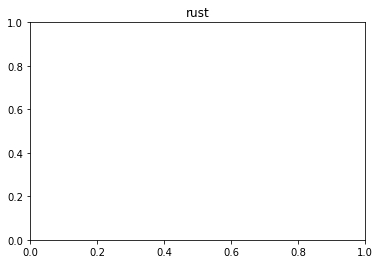

In [32]:
test_image = r'apple-folier-disease\images\train\rust\Train_3.jpg'
image_result = Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result = model.predict(test_image)
print(np.argmax(result))
categories=['healthy','multiple_disease','rust','scab']
plt.title(categories[np.argmax(result)])
plt.show()